In [1]:
import pickle
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def convert_data(data):
    sentence = data[0]
    corpus = [' '.join(item) for item in sentence]
    label = data[1]
    empty_idx = []
    for i in range(len(corpus)):
        if corpus[i] == '':
            empty_idx.append(i)
    empty_idx.sort(reverse=True)
    for i in empty_idx:
        del corpus[i]
        del sentence[i]
        del label[i]
    label = np.array(label)
    data_convert = [sentence, label]
    return data_convert, corpus
    
def glove_dict():
    embedding_dict = {}

    # Open the GloVe embedding file
    glove_dir = 'Embedding/glove.6B.100d.txt'
    file = open(glove_dir, encoding="utf8")

    for line in file:
        # Spilt the word and its embedding vector
        line_list = line.split(' ')
        word = line_list[0]
        embeddings = np.asarray(line_list[1:], dtype='float32')

        # Store the word and its embedding vector in a dictionary
        embedding_dict[word] = embeddings

    file.close()

    # Store the dictionary as a pickle file to reduce thw overhead of loading
    with open(f'Embedding/glove_dict_6b_100d.pickle', "wb") as file:
        pickle.dump(embedding_dict, file)

    return embedding_dict

def embedding_matrix(corpus, VOCAB_SIZE):
    # Try to load GloVe embedding dictionary if it exists. If not, create one
    try:
        with open(f'Embedding/glove_dict_6b_100d.pickle', "rb") as file:
            glove_embedding = pickle.load(file)
    except:
        glove_embedding = glove_dict()

    # Initialize and fit Keras tokenizer to convert words to integers
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(corpus)

    # Save the tokenizer as a pickle file so that the same tokenizer (word-integer)
    # mapping can be used during testing time
    with open('Tokenizer/tokenizer.pickle', "wb") as file:
        pickle.dump(tokenizer, file)

    # Get an word-integer dictionary and use that to create an weight matrix
    # i-th column of weight matrix will have the vector of word with integer value i in dictionary
    word_index = tokenizer.word_index
    embed_matrix = np.zeros((len(word_index) + 1, 100))

    for word, ind in word_index.items():
        # Get the embedding vector from GloVe dictionary, if available
        # Words not in the Glove would have the embedding matrix vector as random values uniformly generated between -0.05 and 0.05
        embedding_vector = glove_embedding.get(word)

        if embedding_vector is not None:
            embed_matrix[ind] = embedding_vector
        else:
            embed_matrix[ind] = np.array([np.random.uniform(-0.05, 0.05) for _ in range(100)])

    return embed_matrix, tokenizer

In [4]:
with open('title_data.pickle', "rb") as file:
        data = pickle.load(file)

In [5]:
sen = data[0]
lab = data[1]

In [6]:
train_data = [sen[0:17000], lab[0:17000]]
test_data = [sen[17000:], lab[17000:]]

In [7]:
MAX_SEQ_LEN = 30
VOCAB_SIZE = 20000

In [8]:
train_data, corpus = convert_data(train_data)
embed_matrix, tokenizer = embedding_matrix(corpus, VOCAB_SIZE)
sequence = lambda sentence: tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(sentence), maxlen=MAX_SEQ_LEN)
process = lambda item: (sequence(item[0]), item[1])
train_data = process(train_data)

In [9]:
embed_matrix.shape

(13779, 100)

In [10]:
lam = tf.keras.regularizers.L2(l2=0.05)
embedding = tf.keras.layers.Embedding(input_dim=embed_matrix.shape[0], output_dim=100, weights=[embed_matrix], input_length=MAX_SEQ_LEN, trainable=False)
translation = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=lam))
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, kernel_regularizer=lam))

In [11]:
input_layer = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embed_layer = embedding(input_layer)
translate_layer = translation(embed_layer)
lstm_layer = lstm(translate_layer)
dense_layer = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=lam)(lstm_layer)
dropout_layer = tf.keras.layers.Dropout(0.2)(dense_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_layer)

In [12]:
model = tf.keras.Model(input_layer, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 100)           1377900   
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 100)           10100     
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101   

In [13]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [14]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=6, verbose=1, factor=0.5, min_lr=0.00001)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

_, tmpfn = tempfile.mkstemp()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)

callbacks = [model_checkpoint, learning_rate_reduction]

In [15]:
X_train = train_data[0]
y_train = train_data[1]

In [16]:
history = model.fit(x=X_train, y=y_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=callbacks)

Epoch 1/150
119/119 [==============================] - 9s 31ms/step - loss: 3.6619 - accuracy: 0.7535 - val_loss: 0.7479 - val_accuracy: 0.8974
Epoch 2/150
119/119 [==============================] - 2s 18ms/step - loss: 0.6299 - accuracy: 0.9051 - val_loss: 0.5147 - val_accuracy: 0.8962
Epoch 3/150
119/119 [==============================] - 2s 17ms/step - loss: 0.4908 - accuracy: 0.9096 - val_loss: 0.4570 - val_accuracy: 0.8938
Epoch 4/150
119/119 [==============================] - 2s 17ms/step - loss: 0.4360 - accuracy: 0.9079 - val_loss: 0.3934 - val_accuracy: 0.8956
Epoch 5/150
119/119 [==============================] - 2s 17ms/step - loss: 0.3759 - accuracy: 0.9079 - val_loss: 0.3573 - val_accuracy: 0.8885
Epoch 6/150
119/119 [==============================] - 2s 15ms/step - loss: 0.4708 - accuracy: 0.8540 - val_loss: 0.4554 - val_accuracy: 0.8980
Epoch 7/150
119/119 [==============================] - 2s 14ms/step - loss: 0.4256 - accuracy: 0.9062 - val_loss: 0.3877 - val_accuracy:

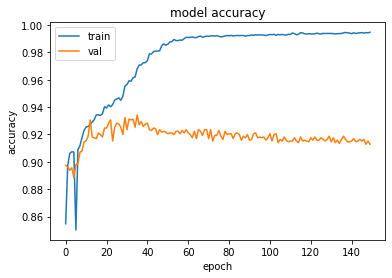

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

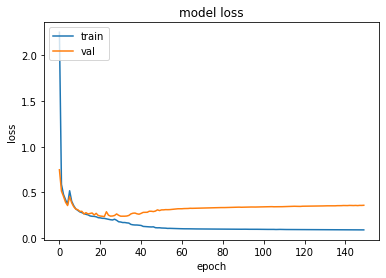

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
with open('Tokenizer/tokenizer.pickle', "rb") as file:
        tokenizer = pickle.load(file)
sequence = lambda sentence: tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(sentence), maxlen=MAX_SEQ_LEN)
process = lambda item: (sequence(item[0]), item[1])
test_data = process(test_data)

In [20]:
X_test = test_data[0]
y_test = np.array(test_data[1])

In [21]:
X_test.shape, y_test.shape

((3242, 30), (3242,))

In [22]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss: {:.2f}, Test Accuracy: {:.2f}%\n".format(loss, (accuracy*100)))

102/102 [==============================] - 0s 4ms/step - loss: 0.3677 - accuracy: 0.9146
Test Loss: 0.37, Test Accuracy: 91.46%



In [23]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

Text(0.5, 33.0, 'Predicted labels')

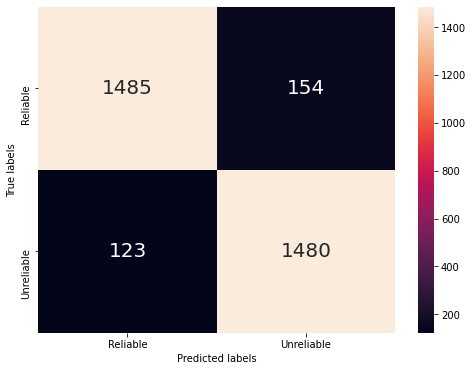

In [24]:
plt.figure(figsize=(8, 6))
ticks = ['Reliable', 'Unreliable']
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', xticklabels=ticks, yticklabels=ticks, annot_kws={"size":20})
plt.ylabel("True labels")
plt.xlabel("Predicted labels")

<AxesSubplot:>

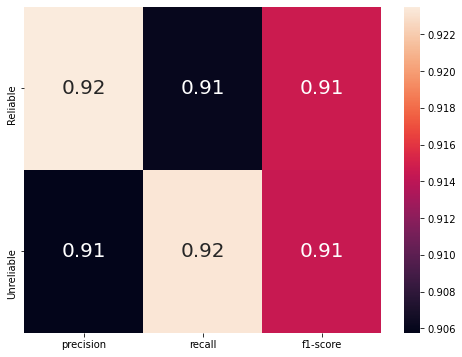

In [25]:
plt.figure(figsize=(8, 6))
report = classification_report(y_test, y_pred, output_dict=True, target_names=ticks)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :2].T, annot=True, annot_kws={"size":20})

In [26]:
tf.keras.models.save_model(model, 'title_model.h5')

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
y_pred = model.predict(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

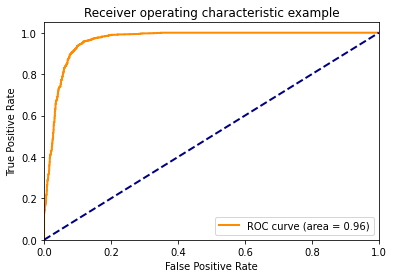

In [28]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

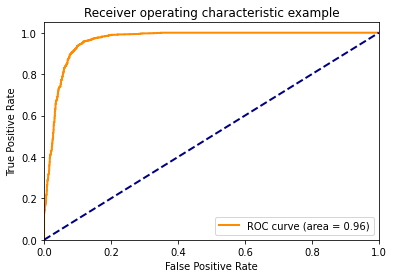

In [29]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()